# CO₂/N₂ Adsorption & IAST Analysis Notebook

*Auto-generated on 2025-10-10 09:35:34*


This notebook is structured so that **each Part is one cell**, matching the typical structure of a project PDF.  
You can rename the headings to exactly match your PDF's parts. The code is ready to run with your data.

**Assumptions & notes:**
- `mg` refers to **Mg-MOF-74**.
- Materials detected from file names include: `UTSA-20`, `UTSA-80`, `ZIF-8`, `NOTT-300`, and `Mg-MOF-74`.
- Suffixes: `P` = *pure-component dataset*, `H` = *Henry's coefficient dataset*.
- `PA-*.csv` = *Pore Analysis* inputs (format-agnostic plotting + summary provided).
- Gases detected from file names: `CO2`, `N2`.
- File name format is treated flexibly, e.g. `UTSA-20-P-CO2.csv`, `ZIF-8-H-N2.csv`, `PA-UTSA-20.csv`, etc.

**What you'll need installed (in your environment):**
```bash
pip install numpy pandas matplotlib pyiast scipy
```
> If `pyiast` is not available, the notebook will still run basic steps, but IAST and model fits will be skipped until you install it.


## Detected CSV files

| File | Size (KB) |
|---|---:|
| `Mg-H-CO2.csv` | 0.9 |
| `Mg-H-N2.csv` | 0.9 |
| `Mg-P-CO2.csv` | 2.9 |
| `Mg-P-N2.csv` | 2.6 |
| `NOTT-H-CO2.csv` | 0.9 |
| `NOTT-H-N2.csv` | 0.9 |
| `NOTT-P-CO2.csv` | 3.1 |
| `NOTT-P-N2.csv` | 2.6 |
| `PA-Mg.csv` | 1.2 |
| `PA-NOTT-300.csv` | 1.2 |
| `PA-UTSA-20.csv` | 1.2 |
| `PA-UTSA-80.csv` | 1.2 |
| `PA-ZIF-8.csv` | 1.2 |
| `UTSA-20-H-CO2.csv` | 0.9 |
| `UTSA-20-H-N2.csv` | 0.9 |
| `UTSA-20-P-CO2.csv` | 2.8 |
| `UTSA-20-P-N2.csv` | 2.6 |
| `UTSA-80-H-CO2.csv` | 0.9 |
| `UTSA-80-H-N2.csv` | 0.9 |
| `UTSA-80-P-CO2.csv` | 2.6 |
| `UTSA-80-P-N2.csv` | 2.6 |
| `ZIF-8-H-CO2.csv` | 0.9 |
| `ZIF-8-H-N2.csv` | 0.6 |
| `ZIF-8-P-CO2.csv` | 2.6 |
| `ZIF-8-P-N2.csv` | 0.6 |


In [3]:

# Part 0 — Environment & utilities
import os
import re
from typing import Dict, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
DATA_DIR = os.path.join(os.getcwd(), "CSV")
# Try to import pyiast
try:
    import pyiast
    from pyiast import ModelIsotherm, iast
    HAVE_PYIAST = True
except Exception as e:
    HAVE_PYIAST = False
    print("pyiast not available. Install with: pip install pyiast")
    print("IAST/model-fitting cells will skip gracefully.")

# Matplotlib defaults (no specific colors set)
plt.rcParams["figure.figsize"] = (6.5, 4.2)
plt.rcParams["axes.grid"] = True

import os
DATA_DIR = os.path.join(os.getcwd(), "CSV")

def parse_filename(fname: str) -> Dict[str, Optional[str]]:
    """
    Robust parser for file names like:
      - UTSA-20-P-CO2.csv
      - ZIF-8-H-N2.csv
      - PA-UTSA-20.csv
      - Mg-P-CO2.csv  (Mg = Mg-MOF-74)
      - PA-Mg.csv

    Returns dict with keys:
      kind ('PA' or 'ISO'), material, mode ('P' or 'H'), gas ('CO2' or 'N2'), raw
    """
    base = os.path.splitext(os.path.basename(fname))[0]
    parts = base.split("-")
    d = {"raw": base, "kind": "ISO", "material": None, "mode": None, "gas": None}
    # PA prefix
    if base.startswith("PA-"):
        d["kind"] = "PA"
        d["material"] = base[3:]
        return d

    # Heuristics: last token often gas; one before often mode (P/H)
    if parts[-1] in ("CO2", "N2"):
        d["gas"] = parts[-1]
        parts = parts[:-1]
    if parts and parts[-1] in ("P", "H"):
        d["mode"] = parts[-1]
        parts = parts[:-1]

    # Remaining parts compose the material name
    material = "-".join(parts)
    if material == "Mg":
        material = "Mg-MOF-74"
    d["material"] = material if material else None
    return d

def read_isotherm_csv(path: str) -> pd.DataFrame:
    """
    Robust isotherm reader.
    - Sniffs delimiter (',' or ';'), falls back appropriately.
    - Accepts European decimals (',' -> '.').
    - Accepts many header variants and headerless two-column files.
    - Returns columns: ['P','q'] and optional ['T'].
    """
    import pandas as pd, numpy as np, re

    # 1) Try to sniff delimiter; fall back to common ones
    try:
        df = pd.read_csv(path, sep=None, engine="python")
    except Exception:
        df = None
    if df is None or df.shape[1] == 1:
        for sep in [",", ";", r"\s+"]:
            try:
                df = pd.read_csv(path, sep=sep, engine="python")
                break
            except Exception:
                df = None
        if df is None:
            return pd.DataFrame(columns=["P","q","T"])

    # 2) Convert comma decimals if present
    for c in df.columns:
        if df[c].dtype == object:
            try:
                df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", "."), errors="ignore")
            except Exception:
                pass

    # 3) Normalize headers: strip spaces/brackets/()// and lowercase
    norm = {}
    for c in df.columns:
        cl = re.sub(r"[\s\[\]\(\)/]", "", str(c)).lower()
        norm[c] = cl
    df = df.rename(columns=norm)

    # 4) If headerless (pure numeric) guess first two columns
    if df.shape[1] >= 2 and not any(k in df.columns for k in ["p","pressure","bar","pbar","pkpa","ppa"]):
        # leave as is; we will pick first two numeric columns below if needed
        pass

    # 5) Find pressure and loading columns
    # Pressure candidates
    P_candidates = [c for c in df.columns if c.startswith("p") or "press" in c or c in ["bar","pbar","pkpa","ppa"]]
    # Loading candidates
    q_candidates = [c for c in df.columns if any(k in c for k in
                     ["q","load","uptake","mmolg","mmol/g","adsorption","amount","nmmolg","nmmolgg"])]

    # Fallback: if nothing matched, try "first two numeric-looking columns"
    if not P_candidates or not q_candidates:
        numeric_cols = [c for c in df.columns if pd.to_numeric(df[c], errors="coerce").notna().sum() > 0]
        if len(numeric_cols) >= 2:
            P_candidates = P_candidates or [numeric_cols[0]]
            q_candidates = q_candidates or [numeric_cols[1]]

    if not P_candidates or not q_candidates:
        return pd.DataFrame(columns=["P","q","T"])

    Pcol, qcol = P_candidates[0], q_candidates[0]
    out = pd.DataFrame({"P": pd.to_numeric(df[Pcol], errors="coerce"),
                        "q": pd.to_numeric(df[qcol], errors="coerce")})

    # Optional T
    T_candidates = [c for c in df.columns if c in ["t","temp","temperature","temperaturek","temperaturec"] or "temp" in c]
    if T_candidates:
        out["T"] = pd.to_numeric(df[T_candidates[0]], errors="coerce")

    return out.dropna(subset=["P","q"]).reset_index(drop=True)

def low_pressure_henry_coefficient(df: pd.DataFrame, pmax: float = 0.05) -> Optional[float]:
    """
    Estimate Henry's coefficient from the slope dq/dP near P=0.
    Uses linear fit for data with P <= pmax (bar). If units are not bar, adjust upstream.
    Returns H in units of q/P (e.g., mmol g^-1 bar^-1).
    """
    if "P" not in df.columns or "q" not in df.columns:
        return None
    sub = df[df["P"] <= pmax].copy()
    if len(sub) < 3:
        # If too few points under pmax, take the first 5% of points
        n = max(3, int(0.05 * len(df)))
        sub = df.head(n).copy()
    if len(sub) < 3:
        return None
    # Linear fit q ~ H*P
    P = sub["P"].values
    q = sub["q"].values
    H, _, _, _ = np.linalg.lstsq(P.reshape(-1,1), q, rcond=None)
    return float(H[0])

def fit_isotherm_model(df: pd.DataFrame, model: str = "Langmuir"):
    """
    Fit a simple pyiast ModelIsotherm to the data.
    Supported models: 'Langmuir', 'LangmuirFreundlich', 'DualSiteLangmuir'
    Returns a fitted ModelIsotherm or None if pyiast unavailable.
    """
    if not HAVE_PYIAST:
        return None
    model_map = {
        "Langmuir": "Langmuir",
        "LangmuirFreundlich": "Langmuir-Freundlich",
        "DualSiteLangmuir": "DSLangmuir"
    }
    mname = model_map.get(model, "Langmuir")
    try:
        iso = ModelIsotherm(df, loading_key="q", pressure_key="P", model=mname)
        return iso
    except Exception as e:
        print("Model fit failed:", e)
        return None

def iast_selectivity(iso1, iso2, y1: float, y2: float, P_total: float) -> Optional[float]:
    """
    Compute IAST selectivity S_(1/2) = (x1/x2) / (y1/y2)
    where component 1 is e.g. CO2, component 2 is N2.
    Requires fitted ModelIsotherm objects (pyiast).
    """
    if not HAVE_PYIAST:
        return None
    try:
        res = iast([y1, y2], [iso1, iso2], P=P_total)
        x1, x2 = res
        S = (x1/x2) / (y1/y2)
        return float(S)
    except Exception as e:
        print("IAST failed:", e)
        return None

def detect_unit_from_column_name(colname: str) -> Optional[str]:
    """
    Try to detect pressure unit from column name.
    Returns 'bar', 'kPa', 'Pa' or None.
    """
    cl = colname.lower()
    if "bar" in cl:
        return "bar"
    if "kpa" in cl:
        return "kPa"
    if "pa" in cl:
        return "Pa"
    return None

def to_bar(P: np.ndarray, unit: Optional[str]) -> np.ndarray:
    if unit == "bar":
        return P
    if unit == "kPa":
        return P / 100.0
    if unit == "Pa":
        return P / 1.0e5
    return P  # assume bar if unknown


In [4]:

# Part 1 — Load & catalog datasets
import glob

paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
catalog = []
dfs = {}

for p in paths:
    meta = parse_filename(p)
    try:
        df_raw = pd.read_csv(p)
        # detect pressure unit from column names (best effort)
        pcol = None
        for c in df_raw.columns:
            if c.lower().startswith("p") or "press" in c.lower():
                pcol = c
                break
        unit = detect_unit_from_column_name(pcol) if pcol else None
        std = read_isotherm_csv(p)
        if "P" in std.columns:
            std["P"] = to_bar(std["P"].values, unit)
        dfs[os.path.basename(p)] = std
        catalog.append({**meta, "file": os.path.basename(p), "npoints": len(std)})
    except Exception as e:
        catalog.append({**meta, "file": os.path.basename(p), "npoints": 0, "error": str(e)})

catalog_df = pd.DataFrame(catalog).sort_values(["kind","material","mode","gas","file"], na_position="last")
catalog_df.reset_index(drop=True, inplace=True)
catalog_df


KeyError: 'kind'

/var/folders/dx/xv7x30v570z3ws2jqm2gr12w0000gn/T/ipykernel_48453/2341821589.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


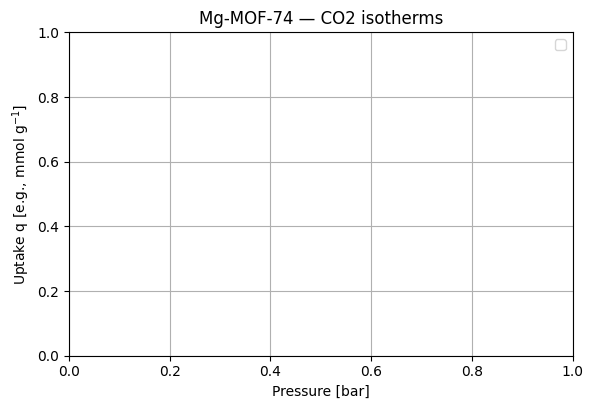

/var/folders/dx/xv7x30v570z3ws2jqm2gr12w0000gn/T/ipykernel_48453/2341821589.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


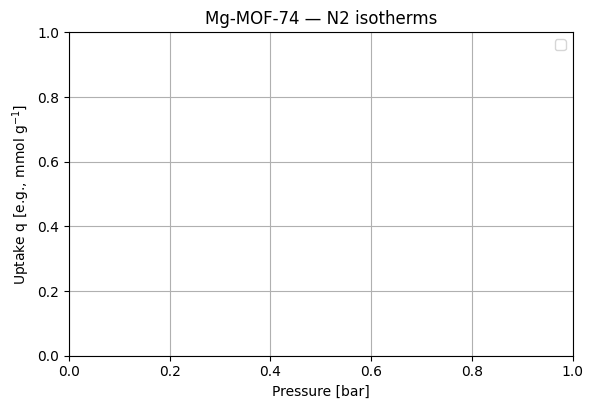

/var/folders/dx/xv7x30v570z3ws2jqm2gr12w0000gn/T/ipykernel_48453/2341821589.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


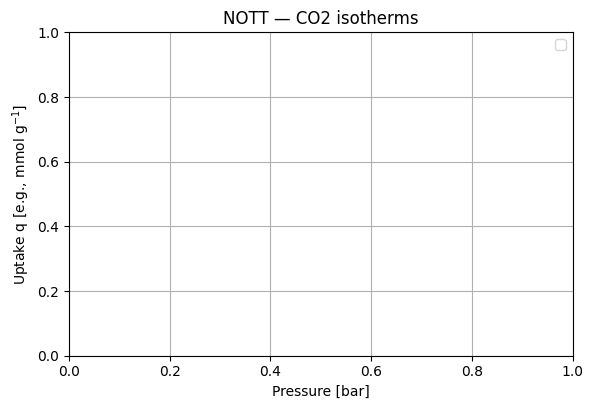

/var/folders/dx/xv7x30v570z3ws2jqm2gr12w0000gn/T/ipykernel_48453/2341821589.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


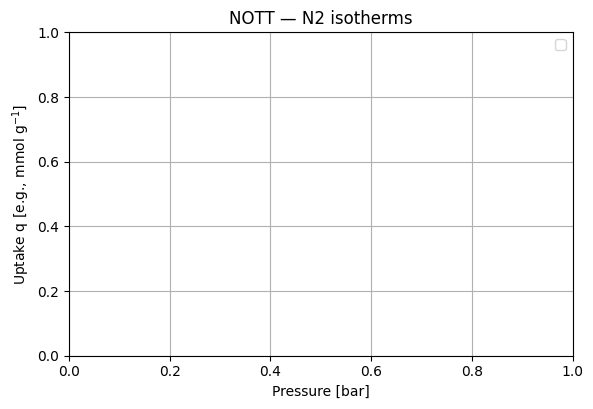

/var/folders/dx/xv7x30v570z3ws2jqm2gr12w0000gn/T/ipykernel_48453/2341821589.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


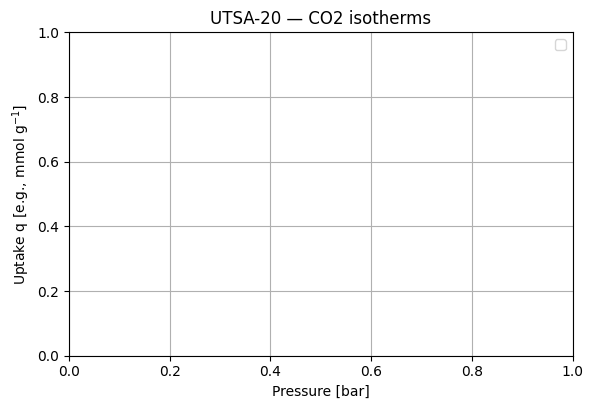

/var/folders/dx/xv7x30v570z3ws2jqm2gr12w0000gn/T/ipykernel_48453/2341821589.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


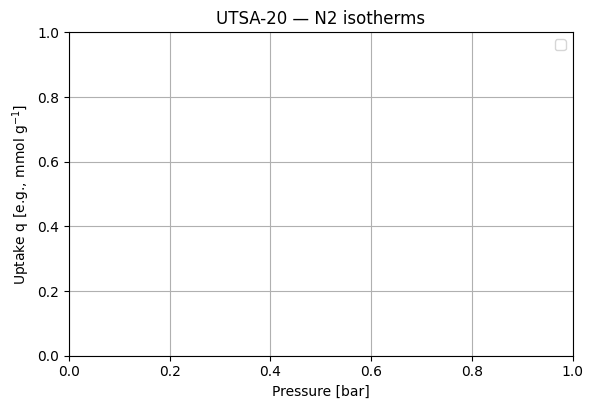

/var/folders/dx/xv7x30v570z3ws2jqm2gr12w0000gn/T/ipykernel_48453/2341821589.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


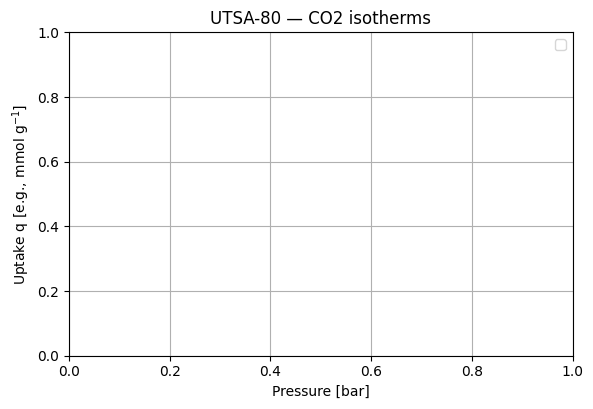

/var/folders/dx/xv7x30v570z3ws2jqm2gr12w0000gn/T/ipykernel_48453/2341821589.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


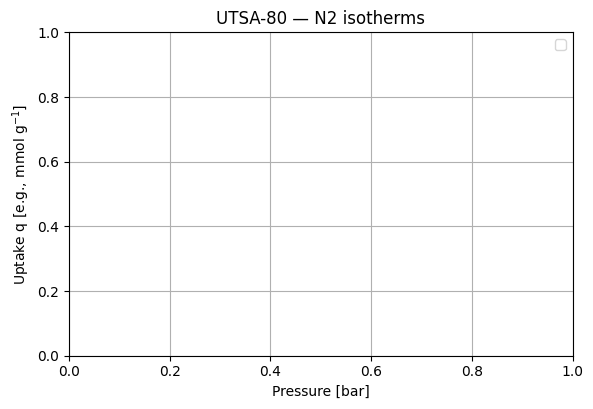

/var/folders/dx/xv7x30v570z3ws2jqm2gr12w0000gn/T/ipykernel_48453/2341821589.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


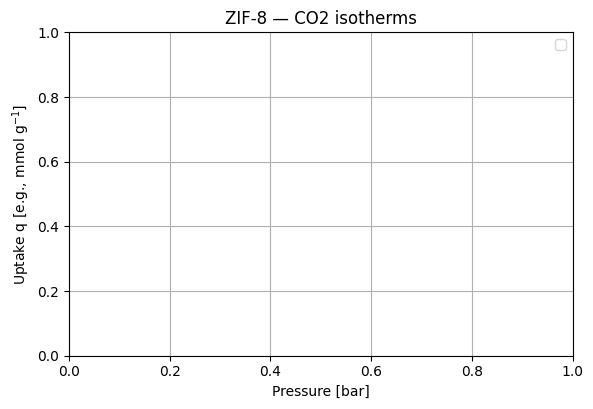

/var/folders/dx/xv7x30v570z3ws2jqm2gr12w0000gn/T/ipykernel_48453/2341821589.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


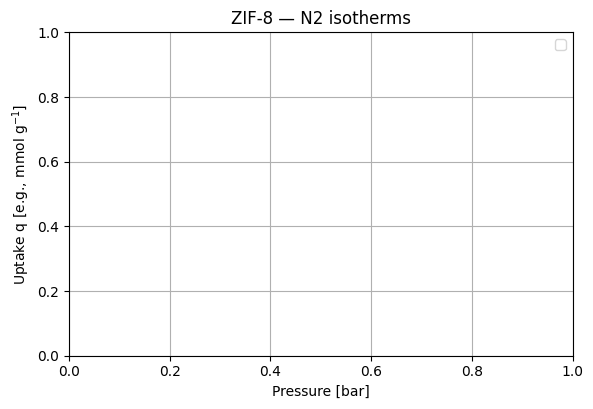

In [ ]:

# Part 2 — Visualize pure-component isotherms (per material & gas)
import math

materials = sorted(set([row["material"] for _, row in catalog_df[catalog_df["kind"]=="ISO"].iterrows() if row["material"]]))
gases = ["CO2", "N2"]

for mat in materials:
    for gas in gases:
        rows = catalog_df[(catalog_df["kind"]=="ISO") & (catalog_df["material"]==mat) & (catalog_df["gas"]==gas)]
        if len(rows)==0:
            continue
        rowsP = rows[rows["mode"]=="P"]
        rows_use = rowsP if len(rowsP)>0 else rows
        plt.figure()
        for _, r in rows_use.iterrows():
            key = r["file"]
            df = dfs.get(key, pd.DataFrame())
            if len(df)>0 and "P" in df.columns and "q" in df.columns:
                plt.plot(df["P"].values, df["q"].values, marker="o", linestyle="-", label=key)
        plt.xlabel("Pressure [bar]")
        plt.ylabel("Uptake q [e.g., mmol g$^{-1}$]")
        plt.title(f"{mat} — {gas} isotherms")
        plt.legend()
        plt.show()


In [ ]:

# Part 3 — Henry's coefficients (from low-P slope) and comparison to '-H-' files if present
henry_rows = []
for _, r in catalog_df[catalog_df["kind"]=="ISO"].iterrows():
    key = r["file"]
    df = dfs.get(key, pd.DataFrame())
    if len(df)>0 and "P" in df.columns and "q" in df.columns:
        H = low_pressure_henry_coefficient(df, pmax=0.05)  # assumes P in bar
        henry_rows.append({"file": key, "material": r["material"], "gas": r["gas"], "H_est_slope": H})

henry_df = pd.DataFrame(henry_rows).sort_values(["material","gas","file"]).reset_index(drop=True)
henry_df


KeyError: 'material'

In [ ]:

# Part 4 — Fit isotherm models (Langmuir then try DSL if needed)
fit_rows = []
fit_objects = {}

if not HAVE_PYIAST:
    print("Skipping model fitting — pyiast not installed.")
else:
    for mat in sorted(set(catalog_df[catalog_df["kind"]=="ISO"]["material"].dropna())):
        for gas in ["CO2","N2"]:
            rows = catalog_df[(catalog_df["kind"]=="ISO") & (catalog_df["material"]==mat) & (catalog_df["gas"]==gas)]
            if len(rows)==0:
                continue
            row = rows[rows["mode"]=="P"].head(1)
            if len(row)==0:
                row = rows.head(1)
            r = row.iloc[0]
            df = dfs.get(r["file"], pd.DataFrame())
            if len(df)<3 or "P" not in df.columns or "q" not in df.columns:
                continue
            iso = fit_isotherm_model(df, model="Langmuir")
            model_name = "Langmuir"
            if iso is None:
                continue
            try:
                q_pred = iso.loading(df["P"].values)
                rmse = float(np.sqrt(np.mean((q_pred - df["q"].values)**2)))
            except Exception as e:
                rmse = np.nan

            if (not np.isnan(rmse)) and rmse > 0.2 * (df["q"].max() - df["q"].min() + 1e-6):
                iso2 = fit_isotherm_model(df, model="DualSiteLangmuir")
                if iso2 is not None:
                    try:
                        q_pred2 = iso2.loading(df["P"].values)
                        rmse2 = float(np.sqrt(np.mean((q_pred2 - df["q"].values)**2)))
                        if not np.isnan(rmse2) and (np.isnan(rmse) or rmse2 < rmse):
                            iso = iso2
                            rmse = rmse2
                            model_name = "DualSiteLangmuir"
                    except Exception as e:
                        pass

            fit_objects[(mat, gas)] = iso
            fit_rows.append({"material": mat, "gas": gas, "model": model_name, "rmse": rmse})

fit_summary = pd.DataFrame(fit_rows).sort_values(["material","gas"]).reset_index(drop=True)
fit_summary if len(fit_rows)>0 else "No models fitted."


In [ ]:

# Part 5 — IAST selectivity S_CO2/N2 at y_CO2=0.15, y_N2=0.85 for P in [0.1, 0.2, 0.5, 1, 2, 5] bar
if not HAVE_PYIAST:
    print("Skipping IAST — pyiast not installed.")
else:
    y_co2, y_n2 = 0.15, 0.85
    pressures = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0]

    rows = []
    for mat in sorted(set([k[0] for k in fit_objects.keys()])):
        iso_co2 = fit_objects.get((mat, "CO2"), None)
        iso_n2  = fit_objects.get((mat, "N2"), None)
        if iso_co2 is None or iso_n2 is None:
            continue
        for Ptot in pressures:
            S = iast_selectivity(iso_co2, iso_n2, y_co2, y_n2, Ptot)
            rows.append({"material": mat, "P_total_bar": Ptot, "y_CO2": y_co2, "y_N2": y_n2, "S_CO2_over_N2": S})
    iast_df = pd.DataFrame(rows).sort_values(["P_total_bar","material"]).reset_index(drop=True)
    iast_df if len(rows)>0 else print("No IAST results (missing fits).")


In [ ]:

# Part 6 — Working capacity under PSA (adsorption 1 bar, desorption 0.1 bar), y_CO2=0.15 (approximate)
if not HAVE_PYIAST:
    print("Skipping working capacity — pyiast not installed.")
else:
    y_co2, y_n2 = 0.15, 0.85
    P_ads, P_des = 1.0, 0.1

    rows = []
    for mat in sorted(set([k[0] for k in fit_objects.keys()])):
        iso_co2 = fit_objects.get((mat, "CO2"), None)
        iso_n2  = fit_objects.get((mat, "N2"), None)
        if iso_co2 is None or iso_n2 is None:
            continue
        try:
            q_co2_ads = iso_co2.loading(y_co2 * P_ads)
            q_co2_des = iso_co2.loading(y_co2 * P_des)
            wc = float(q_co2_ads - q_co2_des)
            rows.append({"material": mat, "P_ads": P_ads, "P_des": P_des, "y_CO2": y_co2, "WC_CO2_approx": wc})
        except Exception as e:
            rows.append({"material": mat, "P_ads": P_ads, "P_des": P_des, "y_CO2": y_co2, "WC_CO2_approx": np.nan, "error": str(e)})

    wc_df = pd.DataFrame(rows).sort_values(["material"]).reset_index(drop=True)
    wc_df


In [ ]:

# Part 7 — Pore analysis (PA-*.csv): summary + generic plot
import glob

pa_paths = sorted(glob.glob(os.path.join(DATA_DIR, "PA-*.csv")))

for p in pa_paths:
    name = os.path.basename(p)
    try:
        df = pd.read_csv(p)
        print(f"=== {name} : summary ===")
        display(df.describe(include="all").T)
        cols = list(df.columns)
        if len(cols) >= 2:
            x = df[cols[0]].values
            y = df[cols[1]].values
            plt.figure()
            plt.plot(x, y, marker="o", linestyle="-")
            plt.xlabel(cols[0])
            plt.ylabel(cols[1])
            plt.title(f"{name} — {cols[1]} vs {cols[0]}")
            plt.show()
    except Exception as e:
        print(f"Failed to parse {name}: {e}")


In [ ]:

# Part 8 — Ranking & conclusions (combine selectivity at 1 bar and WC metric)
if HAVE_PYIAST and "iast_df" in globals():
    iast_1bar = iast_df[iast_df["P_total_bar"]==1.0].copy()
    if "wc_df" in globals():
        summary = pd.merge(iast_1bar, wc_df, on="material", how="outer")
    else:
        summary = iast_1bar.copy()

    for col in ["S_CO2_over_N2", "WC_CO2_approx"]:
        if col in summary.columns:
            v = summary[col].astype(float)
            vmin, vmax = np.nanmin(v), np.nanmax(v)
            if vmax - vmin > 1e-12:
                summary[col+"_norm"] = (v - vmin) / (vmax - vmin)
            else:
                summary[col+"_norm"] = np.nan

    norm_cols = [c for c in ["S_CO2_over_N2_norm","WC_CO2_approx_norm"] if c in summary.columns]
    if norm_cols:
        summary["score"] = summary[norm_cols].mean(axis=1)
        summary = summary.sort_values("score", ascending=False)

    summary.reset_index(drop=True, inplace=True)
    summary
else:
    print("IAST results not available; install pyiast and rerun Parts 4–8.")



## Appendix — Reproducibility notes

- **Units**: the loader attempts to detect pressure units from column names; if uncertain, it assumes **bar**.
- **Henry's coefficient**: estimated from a linear fit in the lowest-pressure region (<= 0.05 bar by default).
- **Model fitting**: we try Langmuir first, then Dual-Site Langmuir if the RMSE is poor relative to the data span.
- **IAST**: performed with `pyiast.iast` using fitted models. Results depend on model quality.
- **Working capacity**: approximated from pure-component model loadings at partial pressures (fast proxy). For rigorous mixture loadings, adapt to `pyiast` functions that return component loadings at spreading-pressure equilibrium.
- **Pore analysis (PA)**: format-agnostic summaries & first-two-columns plot; adapt axes labels if your PA files use specific conventions.
